<a href="https://colab.research.google.com/github/meta-inf/qbdiv/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This example is adapted from [Horowitz (2011)](https://www.jstor.org/stable/41057460). See our extended arXiv version for more information.

You will want to run it on a GPU, preferably with good FP64 performance.

In [1]:
!nvidia-smi

Tue Oct 19 09:49:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    66W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install jax==0.2.21 jaxlib==0.1.71 numpy scipy matplotlib

In [3]:
!git clone https://github.com/meta-inf/qbdiv

fatal: destination path 'qbdiv' already exists and is not an empty directory.


In [4]:
cd qbdiv

/content/qbdiv


In [5]:
import numpy as onp
from jax.config import config
config.update("jax_enable_x64", True)
import jax
from jax import numpy as np
from matplotlib import pyplot as plt

import iv, kernels
from data import gtsim_data
from utils import data_split, UniformNystromSampler, log_linspace

%config InlineBackend.figure_format='retina'
%matplotlib inline

In [6]:
B, P, U_VAR = 3, 0.5, 0.5
N = 10000

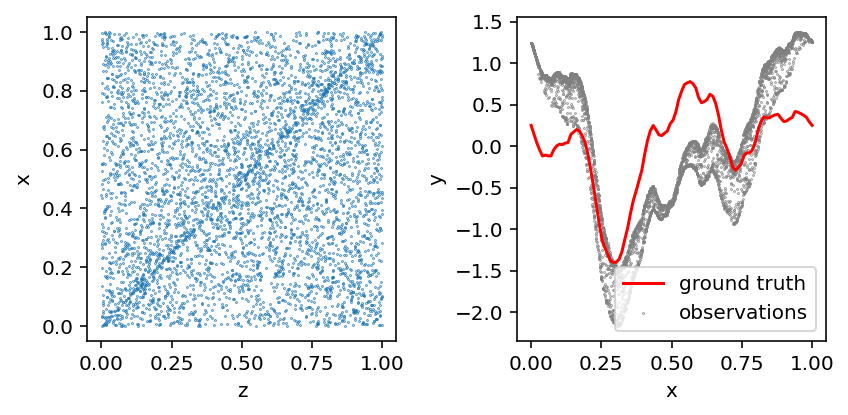

In [7]:
def subsample(t, n): return tuple(a[:n] for a in t)

def visualize_data(dtrain, f0):
  dtrain = subsample(dtrain, 5000)
  plt.figure(figsize=(6, 3))
  plt.subplot(121)
  plt.scatter(dtrain[0], dtrain[1], s=0.1)
  plt.xlabel('z'); plt.ylabel('x')
  plt.subplot(122)
  plt.scatter(dtrain[1], dtrain[2], s=0.1, label='observations', color='gray')
  plt.xlabel('x'); plt.ylabel('y')
  x_grid = np.linspace(0, 1, 100)
  plt.plot(x_grid, f0(x_grid), label='ground truth', color='red')
  plt.legend()
  plt.tight_layout()

(dtrain, dtest), f0, _ = gtsim_data.gen_horowitz_data('circular', B, P, U_VAR, N*2)
visualize_data(dtrain, f0)

Now we compute the quasi-posterior. We use the Matérn/Sobolev-equivalent kernel on $\mathbb{S}^1$, and employ Nyström approximation for the conditional expectation estimator. 



In [8]:
z_nys = UniformNystromSampler(jax.random.PRNGKey(23), mn=50)

# use a small subsample to estimate the bandwidth w/ median trick
Kz = kernels.CircularMaternKernel(B+2*P, x_train=dtrain[0][:5000])
Kx = kernels.CircularMaternKernel(B, x_train=dtrain[1][:5000])

def get_nu(n): return (n/1000)**(1/ (B+2*P+1)) * 20

kiv_predictor = iv.kiv(
  dtrain[0], dtrain[1], dtrain[2], Kz, Kx, lam=U_VAR, nu=get_nu(N), z_nystrom=z_nys)

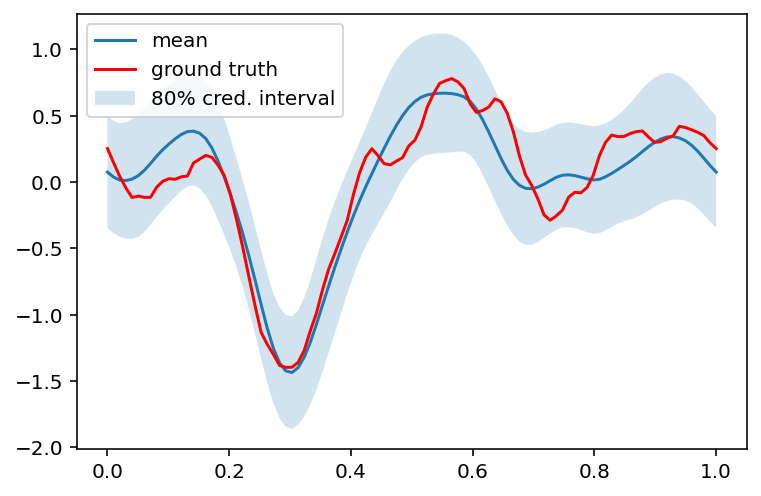

In [9]:
def visualize_pred(pred_fn, f0):
  x_grid = np.linspace(0, 1, 100)
  pred_mean, pred_cov_diag = pred_fn(x_grid[:, None])
  pred_mean = pred_mean.squeeze()
  pred_sd = pred_cov_diag**0.5
  plt.plot(x_grid, pred_mean, label='mean')
  plt.fill_between(x_grid, pred_mean-1.282*pred_sd, pred_mean+1.282*pred_sd,
                   alpha=0.2, label='80% cred. interval')
  plt.plot(x_grid, f0(x_grid), label='ground truth', color='red')
  plt.legend()

visualize_pred(kiv_predictor, f0)

The credible intervals scale gracefully, when the sample size changes ...



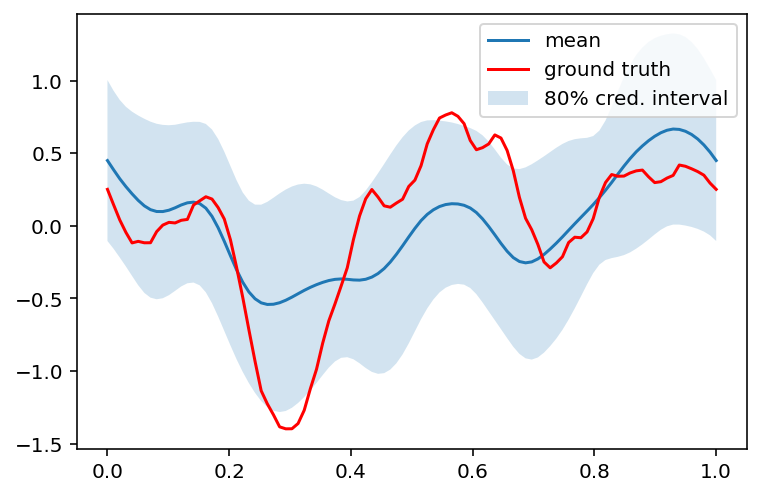

In [10]:
kiv_predictor = iv.kiv(
    *subsample(dtrain, 2000), Kz, Kx, lam=U_VAR, nu=get_nu(2000), z_nystrom=z_nys)
visualize_pred(kiv_predictor, f0)

... or when the instrument becomes less informative. 
(The $L_2$ contraction rate is $O\bigl(n^{-\frac{b}{2(b+2p+1)}}\bigr)$. You can observe it in this example, if you have a performant GPU.)

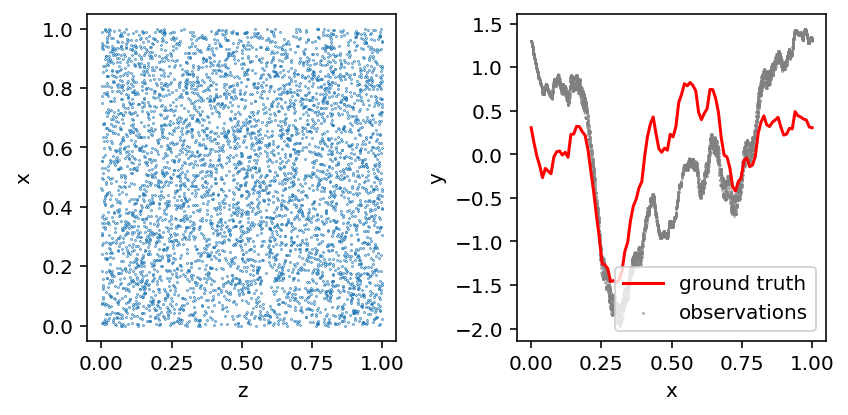

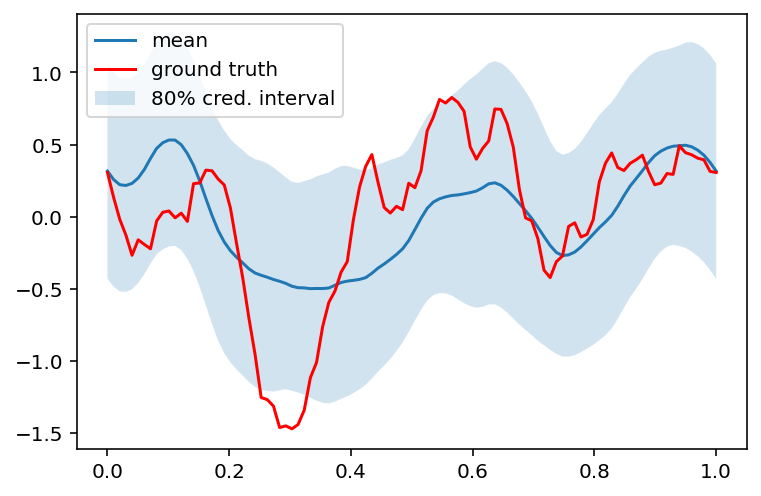

In [11]:
B, P, U_VAR, N = 2, 2, 0.5, 10000
(dtrain, dtest), f0, _ = gtsim_data.gen_horowitz_data('circular', B, P, U_VAR, N*2)
visualize_data(dtrain, f0)

Kz = kernels.CircularMaternKernel(B + 2*P, x_train=dtrain[0][:5000])
Kx = kernels.CircularMaternKernel(B, x_train=dtrain[1][:5000])
kiv_predictor = iv.kiv(
    dtrain[0], dtrain[1], dtrain[2], Kz, Kx, lam=U_VAR, nu=get_nu(N), z_nystrom=z_nys)
plt.figure()
visualize_pred(kiv_predictor, f0)

If you want to bring your own dataset, note that `UniformNystromSampler` is only suitable in this setting as the leverage score is uniformly distributed. In general you should replace it with leverage score sampling, or use a larger ($O(n^{\frac{b+2p}{b+2p+1}})$) number of inducing points. See [Rudi et al. (2015)](https://arxiv.org/abs/1507.04717).

You should also standardize the dataset before use.